# Oil Well Selection Optimization

You work for the mining company OilyGiant. Your task is to find the best location for a new oil well.
Steps to choose the location:

- Collect parameters of oil wells in the selected region: oil quality and reserve volume
- Build a model to predict reserve volume in new wells
- Select oil wells with highest estimated values
- Choose the region with the highest total benefit for selected oil wells

You have data on crude samples from three regions. The parameters of each oil well in the region are already known. Create a model that helps choose the region with the highest profit margin. Analyze potential benefits and risks using bootstrapping technique.

# Data Description

- `id` — Unique identifier of an oil well
- `f0, f1, f2` — Three characteristics about the quality of the oil (the specific meaning is not important, but the characteristics themselves are significant)
- `product` — Volume of reserves in the oil well (thousands of barrels)

**Conditions**:

- Only linear regression is suitable for model training.
- When exploring the region, a study with 500 points is conducted and the best 200 points are selected for profit calculation.
- The budget for developing 200 oil wells is $100 million.
- One barrel of raw materials generates $4.5 in revenue. The revenue from one unit of product is $4500 (the volume of reserves is expressed in thousands of barrels).
- After risk assessment, only regions with a risk of loss below 2.5% should be kept. From those that meet the criteria, select the region with the highest average profit.

# Initialization

In [460]:
# Load libraries

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [461]:
# Load the data into DataFrames
df0 = pd.read_csv('../datasets/geo_data_0.csv')
df1 = pd.read_csv('../datasets/geo_data_1.csv')
df2 = pd.read_csv('../datasets/geo_data_2.csv')

In [462]:
# Print the general/summary information about the DataFrames
df0.info()

# Print a random sample of 5 rows from the DataFrame
df0.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
17357,f5CZs,1.302866,-0.496965,2.259350,114.002484
96449,rYbcI,1.828544,0.421368,0.727069,100.865955
71925,vfDK2,0.219785,0.974053,5.237866,157.783710
58668,uqdwY,1.680242,-0.304073,2.810213,54.532564
13240,s5aFe,2.242501,0.290043,4.347522,122.507266


In [463]:
# Print the general/summary information about the DataFrames
df1.info()

# Print a random sample of 5 rows from the DataFrame
df1.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
19553,U9oP6,-11.102826,-6.799239,3.997935,110.992147
77912,QGW7x,11.231917,-4.137990,4.993098,134.766305
30129,D4LDE,-2.317892,-10.555614,1.000692,30.132364
49154,XR4EL,-4.287594,-2.285101,3.997063,110.992147
19445,uJh42,-8.701784,-9.515951,2.002678,57.085625


In [464]:
# Print the general/summary information about the DataFrames
df2.info()

# Print a random sample of 5 rows from the DataFrame
df2.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
23471,EFusq,-0.999606,0.486598,4.400714,105.328292
36216,jrYBf,-3.404326,-2.978794,7.649946,164.492663
95180,Cv7zm,0.086729,-0.488144,0.054108,48.032294
53705,c5Ct9,0.148068,-0.799995,-2.366615,45.331630
32526,smTRW,-1.134093,-0.193481,-3.662916,82.026384


## Observations
- The `id` column does not contain relevant information for model predictions.
- None of the three datasets contain missing values, and the data type of all columns is correct.
- All three datasets are ready to be used in model training.

# Prepare data

## Remove unnecessary columns

In [465]:
# Remove the column 'id' since it will not be used in the analysis
df0 = df0.drop(['id'], axis=1)
df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)

# EDA

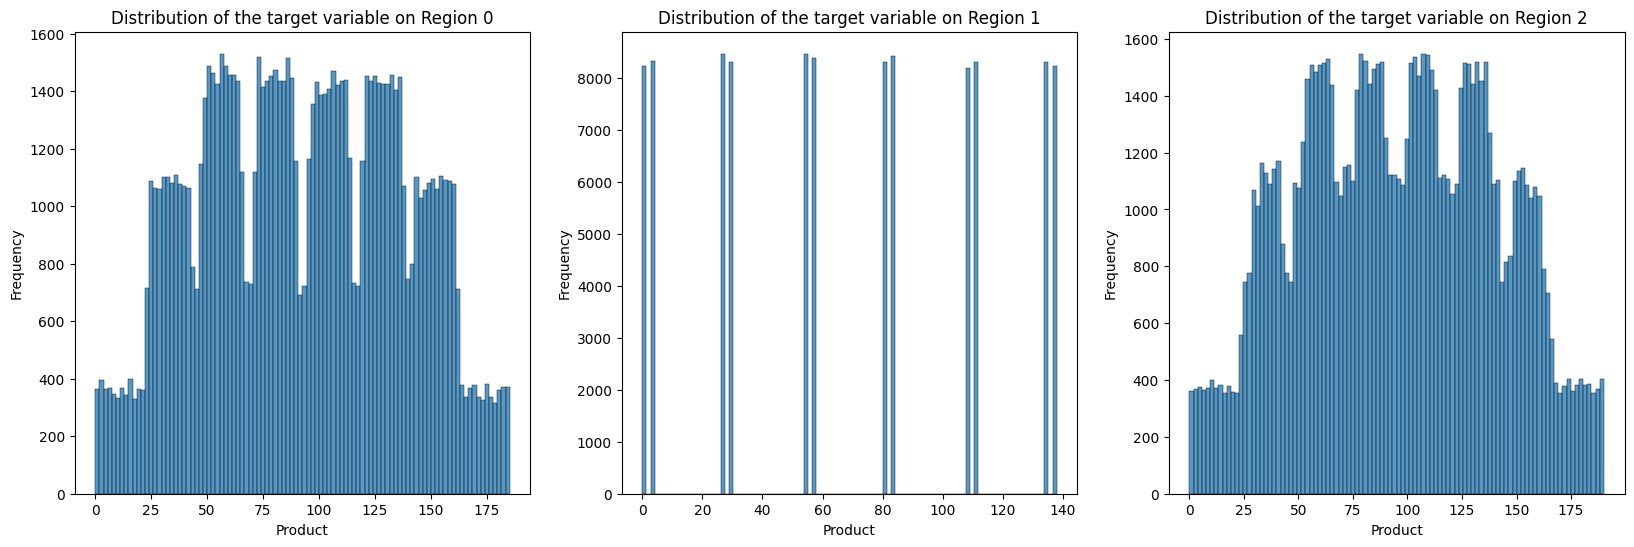

In [466]:
# Create three graphs (side by side) to visualize the distribution of the target variable on all three regions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(df0['product'], bins=100, ax=axes[0])
axes[0].set_title('Distribution of the target variable on Region 0')
axes[0].set_xlabel('Product')
axes[0].set_ylabel('Frequency')
sns.histplot(df1['product'], bins=100, ax=axes[1])
axes[1].set_title('Distribution of the target variable on Region 1')
axes[1].set_xlabel('Product')
axes[1].set_ylabel('Frequency')
sns.histplot(df2['product'], bins=100, ax=axes[2])
axes[2].set_title('Distribution of the target variable on Region 2')
axes[2].set_xlabel('Product')
axes[2].set_ylabel('Frequency')
plt.show()

## Observations

- `Region 1`'s distribution is sharply multimodal, with values concentrated around specific peaks. These discrete peaks might suggest that the data are categorized or binned into certain reserve sizes.

- Since the distributions of the target variable are significantly different across regions, it would be more appropriate to build separate regression models for each region. This way, each model can learn the specific patterns unique to its region without being influenced by the patterns of the others.

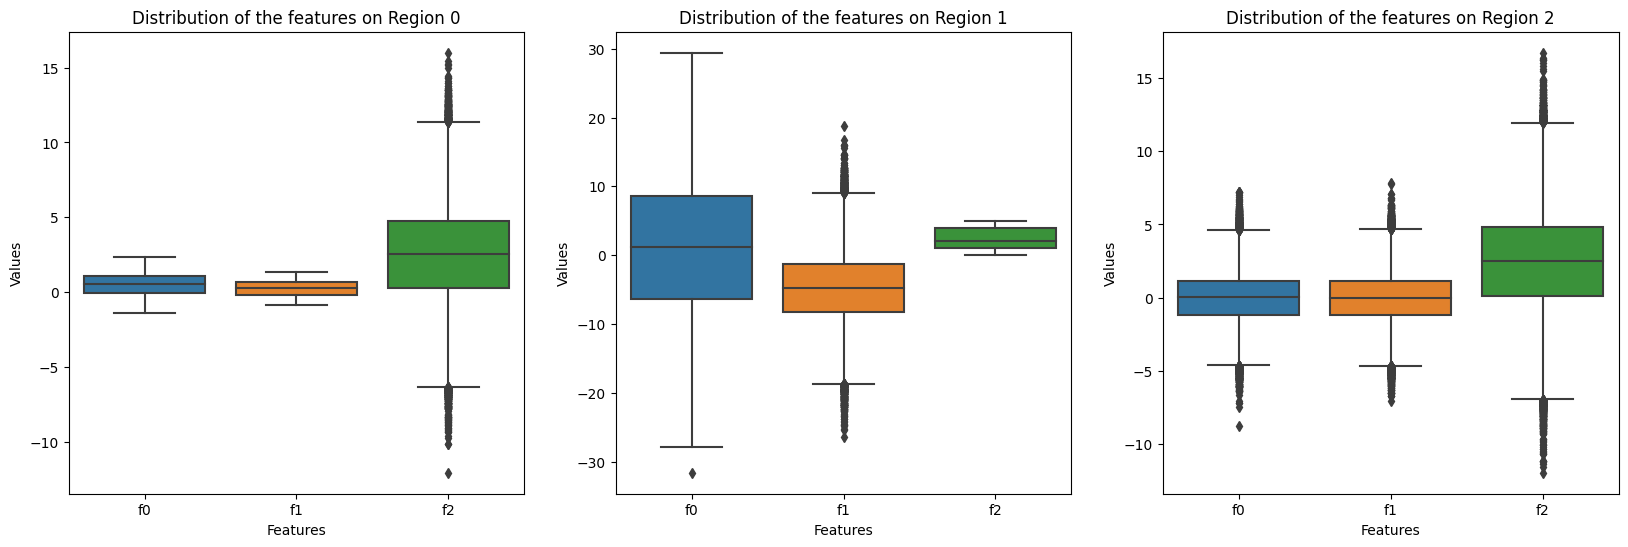

In [467]:
# Create three boxplots (side by side) to visualize the distribution of the features on all three regions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df0.drop(['product'], axis=1), ax=axes[0])
axes[0].set_title('Distribution of the features on Region 0')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Values')
sns.boxplot(data=df1.drop(['product'], axis=1), ax=axes[1])
axes[1].set_title('Distribution of the features on Region 1')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Values')
sns.boxplot(data=df2.drop(['product'], axis=1), ax=axes[2])
axes[2].set_title('Distribution of the features on Region 2')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Values')
plt.show()

## Observations

- The differences in distributions for each feature across regions suggest that the relationships between the features and the target variable might also differ by region, supporting the case for building separate models for each region.

- Given the difference in distributions and the presence of outliers, scaling the features would be important for linear regression models. Standard scaling (z-score normalization) could be used, but it's sensitive to outliers. An alternative like RobustScaler, which uses the interquartile range, could be more appropriate as it's designed to handle outliers.

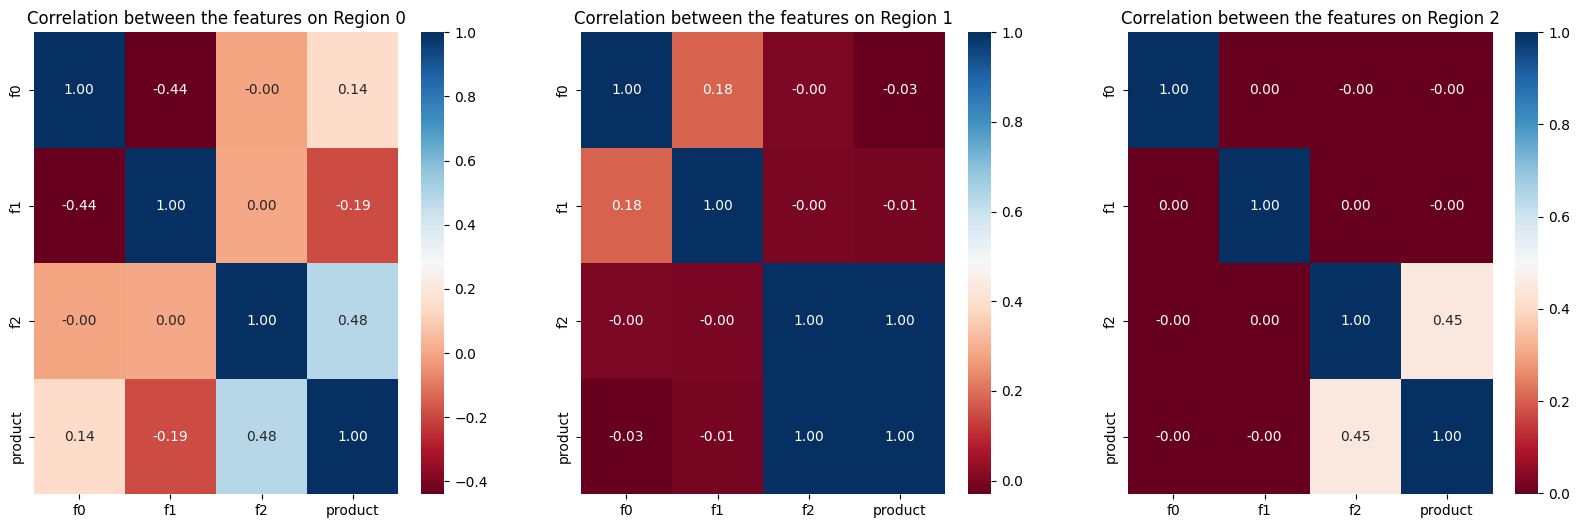

In [468]:
# Create three graphs (side by side) to visualize the correlation between the features on all three regions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(df0.corr(), annot=True, fmt='.2f', cmap='RdBu', ax=axes[0])
axes[0].set_title('Correlation between the features on Region 0')
sns.heatmap(df1.corr(), annot=True, fmt='.2f', cmap='RdBu', ax=axes[1])
axes[1].set_title('Correlation between the features on Region 1')
sns.heatmap(df2.corr(), annot=True, fmt='.2f', cmap='RdBu', ax=axes[2])
axes[2].set_title('Correlation between the features on Region 2')
plt.show()

## Observations

- On all three regions we can observe that **f2** is the most relevant feature, although there are some nuances to this:
    - `Region 0`, has the most balanced correlations between features and target, even when **f0** and **f1** are really close to 0.
    - `Region 1`, **f2** has a very unusual 'perfect' correlation to the target, which can indicate data leakage. This could happen if **f2** is somehow calculated using the target. The other features are practically 0.
    - `Region 2`, just like in the previous region, **f0** and **f1** are practically 0.

# Model construction

## Data Segmentation

In [469]:
# Select a random seed for the experiments
random_state = np.random.RandomState(12345)

In [470]:
# Separate the data into features and target for the Region 0
features0 = df0.drop(['product'], axis=1)
target0 = df0['product']

# Divide the data into training and validation subsets (75:25 ratio)
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(features0, target0, test_size=0.25, random_state=random_state)

In [471]:
# Separate the data into features and target for the Region 1
features1 = df1.drop(['product'], axis=1)
target1 = df1['product']

# Divide the data into training and validation subsets (75:25 ratio)
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(features1, target1, test_size=0.25, random_state=random_state)

In [472]:
# Separate the data into features and target for the Region 2 (drop 'f0' and 'f1' since they have no correlation with the target variable)
features2 = df2.drop(['f0', 'f1', 'product'], axis=1)
target2 = df2['product']

# Divide the data into training and validation subsets (75:25 ratio)
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(features2, target2, test_size=0.25, random_state=random_state)

## Preprocessing

In [473]:
# Scale the features for the Region 0
scaler0 = RobustScaler()
scaler0.fit(features_train0)
features_train0 = scaler0.transform(features_train0)
features_valid0 = scaler0.transform(features_valid0)

In [474]:
# Scale the features for the Region 1
scaler1 = RobustScaler()
scaler1.fit(features_train1)
features_train1 = scaler1.transform(features_train1)
features_valid1 = scaler1.transform(features_valid1)

In [475]:
# Scale the features for the Region 2
scaler2 = RobustScaler()
scaler2.fit(features_train2)
features_train2 = scaler2.transform(features_train2)
features_valid2 = scaler2.transform(features_valid2)

## Model Training

In [476]:
# Create a function to train the model and make predictions
def train_model(features_train, target_train, features_valid, target_valid):
    # Train the model
    model = LinearRegression()
    model.fit(features_train, target_train)

    # Make predictions on the validation set
    predicted_valid = model.predict(features_valid)

    # Calculate the RMSE value
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5

    # Save the predictions and correct answers for the validation set
    predictions = pd.Series(predicted_valid, index=target_valid.index)

    return predicted_valid, rmse, predictions

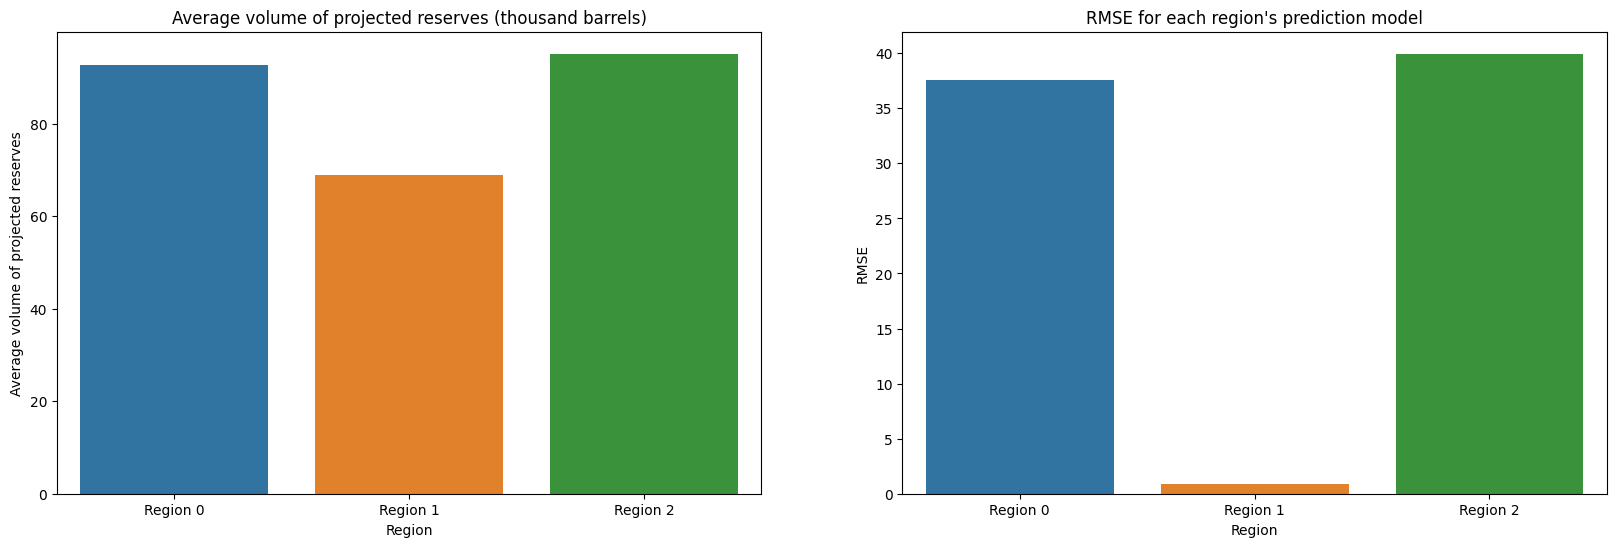

In [477]:
# Train the model and make predictions for each region
predicted_valid0, rmse0, predictions0 = train_model(features_train0, target_train0, features_valid0, target_valid0)
predicted_valid1, rmse1, predictions1 = train_model(features_train1, target_train1, features_valid1, target_valid1)
predicted_valid2, rmse2, predictions2 = train_model(features_train2, target_train2, features_valid2, target_valid2)

# Gather all the predictions' means and RMSE values into a dataframe for comparison
results = pd.DataFrame({'Region': ['Region 0', 'Region 1', 'Region 2'],
                        'Average volume of projected reserves': [predicted_valid0.mean(), predicted_valid1.mean(), predicted_valid2.mean()],
                        'RMSE': [rmse0, rmse1, rmse2]})

# Create two graphs (side by side) to visualize the results
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create a barplot to visualize the average volume of forecasted reserves
sns.barplot(x='Region', y='Average volume of projected reserves', data=results, ax=axes[0])
axes[0].set_title('Average volume of projected reserves (thousand barrels)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Average volume of projected reserves')

# Create a barplot to visualize the RMSE values
sns.barplot(x='Region', y='RMSE', data=results, ax=axes[1])
axes[1].set_title("RMSE for each region's prediction model")
axes[1].set_xlabel('Region')
axes[1].set_ylabel('RMSE')

plt.show()

## Intermediate Conclusion
- The highest average reserves are found in `region 2`, closely followed by `region 0`. However, it is notable that the **RMSE** is considerably high in `region 0 and 2`, indicating a higher level of error in the predictions of oil reserves in these regions. In contrast, `region 1` has a lower average reserve but also has a much lower **RMSE**, suggesting that the model's predictions are more accurate in this region. However, the perfect correlation warrants further investigation to rule out data quality issues or leakage.

# Profit Calculation

## Key values for calculations

In [478]:
# Budget for the development of 200 oil wells is $100 million
budget = 100_000_000

# The revenue from one unit of product is $4500 (the volume of reserves is expressed in thousands of barrels)
income_per_unit = 4_500

# Risk threshold of losses less than 2.5%
risk_threshold = 0.025

# Cost of development of a single well
cost_per_well = budget / 200
print('Cost of development of a single well:', cost_per_well)

# Volume of reserves sufficient to develop a new well without losses
sufficient_volume = cost_per_well / income_per_unit
print('Volume of reserves sufficient to develop a new well without losses:', sufficient_volume)

Cost of development of a single well: 500000.0
Volume of reserves sufficient to develop a new well without losses: 111.11111111111111


### Observations
- Development cost for a single well: `500,000`
- Volume of reserves sufficient to develop a new well without losses: `111.11`

## Sufficient Reserves Volume to Develop a New Well without Losses

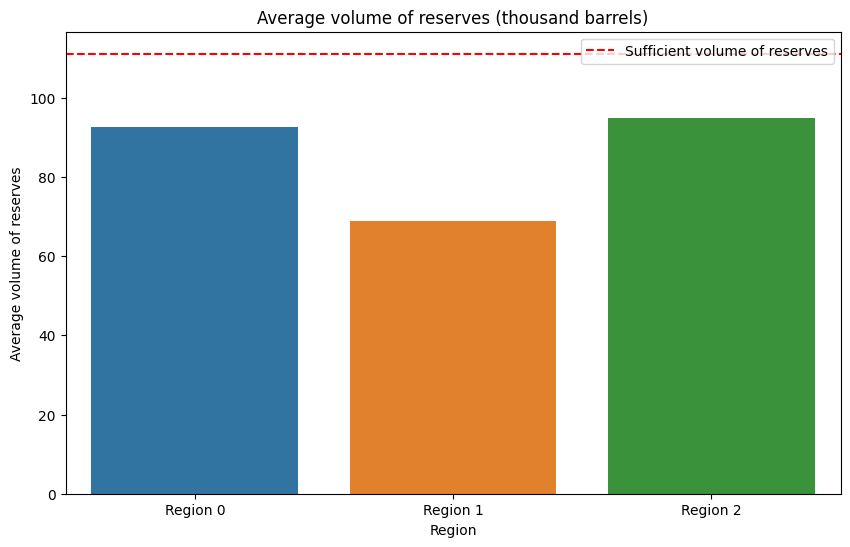

In [479]:
# Store the average volume of reserves and whether the sufficient volume of reserves is enough to develop a new well without losses
results = pd.DataFrame({'Region': ['Region 0', 'Region 1', 'Region 2'],
                        'Average volume of reserves': [target0.mean(), target1.mean(), target2.mean()],
                        'Sufficient volume of reserves': [
                            sufficient_volume > target0.mean(),
                            sufficient_volume > target1.mean(),
                            sufficient_volume > target2.mean()]})

# Create a barplot to visualize the results of the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Average volume of reserves', data=results)
plt.axhline(y=sufficient_volume, color='red', linestyle='--', label='Sufficient volume of reserves')
plt.title('Average volume of reserves (thousand barrels)')
plt.xlabel('Region')
plt.ylabel('Average volume of reserves')
plt.legend()
plt.show()

### Observations
- None of the three regions seem to have a high enough average volume to drill a new well without losses.
- Although `regions 0 and 2` have average volumes closest to what is needed to avoid losses, we must not forget that `region 1` has a lower RMSE.

## Expected total income from the 200 most profitable wells in each region

In [480]:
# Create a function to calculate the expected total income from the top 200 profitable wells for a region
def calculate_profit(actual_volumes, predicted_volumes):
    # Sort the predictions from highest to lowest
    sorted_predictions = predicted_volumes.sort_values(ascending=False)

    # Select the top 200 highest values
    selected = actual_volumes[sorted_predictions.index][:200]

    # Calculate the total expected profit
    total_revenue = (selected * income_per_unit).sum()
    
    return total_revenue - budget

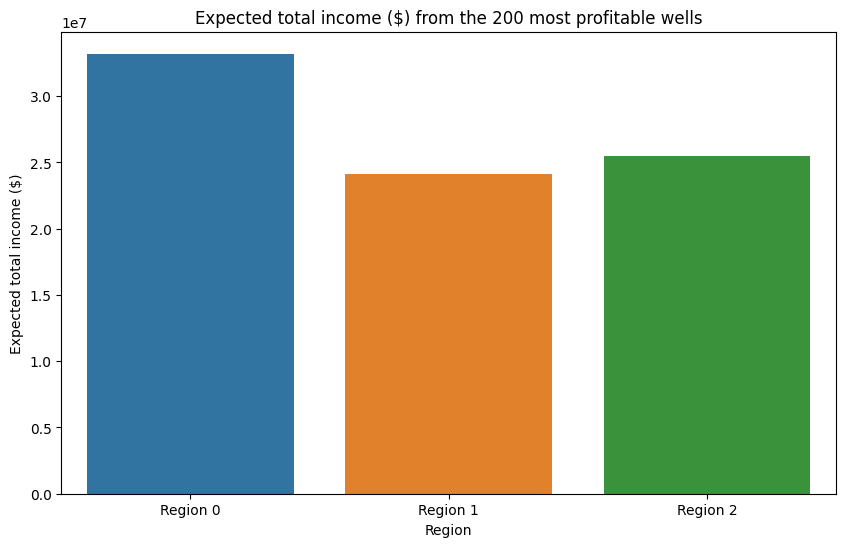

In [481]:
# Calculate the expected total income from the 200 most profitable wells for each region
profit0 = calculate_profit(target_valid0, predictions0)
profit1 = calculate_profit(target_valid1, predictions1)
profit2 = calculate_profit(target_valid2, predictions2)

# Store the expected total income from the 200 most profitable wells for each region
results = pd.DataFrame({'Region': ['Region 0', 'Region 1', 'Region 2'],
                        'Expected total income': [profit0, profit1, profit2]})

# Create a barplot to visualize the results of the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Expected total income', data=results)
plt.title('Expected total income ($) from the 200 most profitable wells')
plt.xlabel('Region')
plt.ylabel('Expected total income ($)')
plt.show()

### Observations
- `Region 0` has the highest expected total income out of the three, followed by `Region 2`, and then `Region 1`.

## Intermediate Conclusion
- Based on the results of the average volume in each region as well as the expected revenues, it is still not possible to determine which region is the best option for creating a new well.

# Risk and Profit Calculation for Each Region

## Bootstrapping with 1000 samples to find the distribution of profit

In [482]:
# Create a function to perform bootstrapping and calculate the distribution of benefits and risks for each region
def bootstrap_profit_and_loss(target, predictions, loop_size = 1_000, sample_size = 500):
    # Initialize the list of benefits
    values = []

    # Combine target and predictions into a DataFrame
    combined = pd.DataFrame({
        'target': target,
        'predictions': predictions
    })

    # Initialize the negative profit counter
    negative_profit_count = 0

    # Performing bootstrapping
    for _ in range(loop_size):
        # Sample the data
        subsample = combined.sample(sample_size, replace=True, random_state=random_state)

        # Separate target and predictions again
        subsample_target = subsample['target']
        subsample_predictions = subsample['predictions']

        # Calculate the profit of the sample and add it to the list of benefits
        profit = calculate_profit(subsample_target, subsample_predictions)
        values.append(profit)
        
        # Count the number of times the profit is negative
        if profit < 0:
            negative_profit_count += 1

    # Convert the list of benefits to a pandas Series
    values = pd.Series(values)

    # Calculate the average profit
    average_profit = values.mean()

    # Calculate the quantile of 2.5%
    lower = values.quantile(risk_threshold)

    # Calculate the quantile of 97.5%
    upper = values.quantile(1 - risk_threshold)

    # Evaluate loss risk
    loss_risk = negative_profit_count / loop_size

    return average_profit, loss_risk, lower, upper

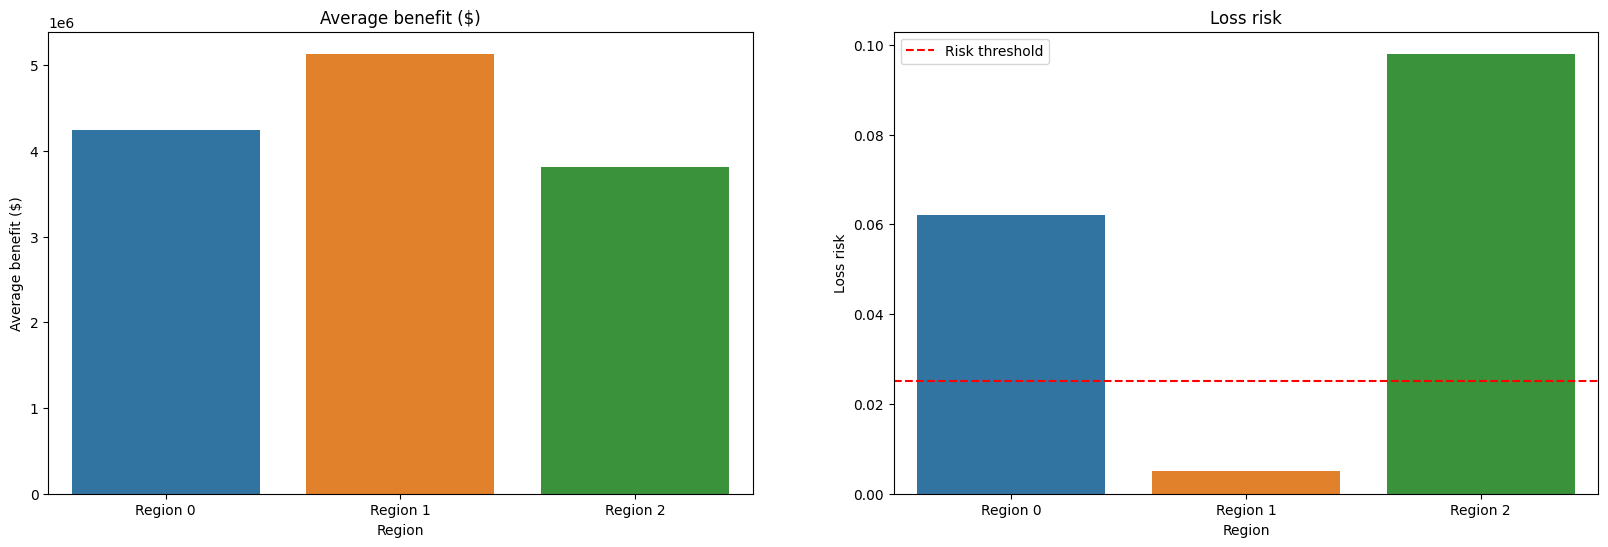

In [483]:
# Store the results of bootstrapping for each region in a dataframe
results = pd.DataFrame({'Region': ['Region 0', 'Region 1', 'Region 2'],
                        'Average benefit': [bootstrap_profit_and_loss(target_valid0, predictions0)[0],
                                            bootstrap_profit_and_loss(target_valid1, predictions1)[0],
                                            bootstrap_profit_and_loss(target_valid2, predictions2)[0]],
                        'Loss risk': [bootstrap_profit_and_loss(target_valid0, predictions0)[1],
                                        bootstrap_profit_and_loss(target_valid1, predictions1)[1],
                                        bootstrap_profit_and_loss(target_valid2, predictions2)[1]]})

# Create a barplot to visualize the results of the comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create a barplot to visualize the average benefit
sns.barplot(x='Region', y='Average benefit', data=results, ax=axes[0])
axes[0].set_title('Average benefit ($)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Average benefit ($)')

# Create a barplot to visualize the loss risk
sns.barplot(x='Region', y='Loss risk', data=results, ax=axes[1])
axes[1].set_title('Loss risk')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Loss risk')
axes[1].axhline(y=risk_threshold, color='red', linestyle='--', label='Risk threshold')
axes[1].legend()

plt.show()

## Intermediate Conclusion
- `Region 1` generally shows the highest average benefit and lowest risk of losses, indicating that this region has the greatest potential to achieve our objective.

# General Conclusion

During this project, a linear regression model was built to predict the volume of reserves in new oil wells based on geological data from three regions. Subsequently, a bootstrapping simulation was performed to estimate the distribution of potential benefits and risks in each region.

- An exploratory data analysis was conducted and a linear regression model was trained for each of the three regions. A linear regression model was fitted for each region using RMSE as the evaluation metric.
- Based on the model predictions, the top 200 wells with the highest predicted volumes of oil reserves were selected for drilling.
- To quantify uncertainty in the drilling decision and estimate potential profit, bootstrapping technique was employed. This provided a distribution of possible benefits and risk of losses.
- The bootstrapping analysis showed that `region 1` exhibits the `highest average benefit` as well as `lowest risk of losses`, suggesting it would be the most promising region for oil exploration.

Based on these results, it has been concluded that `region 1` is the most promising for future well drilling operations as it presents both `the highest average benefit` and `the lowest risk of losses`.